In [ ]:
# This is the basic proportional rate diffusion model from Palmer, Huk and Shadlen '05. 
# In this version, I'm trying to fit conditions in which distance is non-zero (i.e. exclude D0Call). 

# In Python, when you flatten a 2D matrix, it is read row-wise. So first row is read first, 
# then second row etc. This means that I need to exclude indices 0, 5, 10 and 15.

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from math import factorial as fact

In [4]:
# List subjects to fit
subs = ['Sub01', 'Sub02', 'Sub04', 'Sub05', 'Sub06', 'Sub08', 'Sub10', 'Sub11', 'Sub13']
nSub = len(subs)

# Indices to remove: 0, 5, 10, 15
keepId = np.setdiff1d(range(20), [0, 5, 10, 15])
nCD = len(keepId)

# Initialize arrays to hold PC, mean and SD of RT, and # trials 
# for each coherence-distanct combination
# These values are obtained from the .csv files
pCs = np.zeros((nCD, nSub))
mRTs = np.zeros((nCD, nSub))
sdRTs = np.zeros((nCD, nSub))
Ns = np.zeros((nCD, nSub))

# Initialise a variable to hold # correct trials
# This will be computed from Ns and pCs
Rs = np.zeros((nCD, nSub))

In [6]:
# Extract behavioral data (PC, mean and SD of RT, # trials) from csv files
for si in range(nSub):
    csvFile = '../Data/Behavior/' + subs[si] + '_behavData.csv'
    behavData = read_csv(csvFile, header=None)
    
    # Split the file in PC, mean RT and SD RT
    # Flatten each subject's values for ease of programming
    temp = np.array(behavData[0:4]).flatten()
    pCs[:,si] = temp[keepId]
    temp = np.array(behavData[4:8]).flatten()
    mRTs[:,si] = temp[keepId]
    temp = np.array(behavData[8:12]).flatten()
    sdRTs[:,si] = temp[keepId]
    temp = np.array(behavData[12:]).flatten()
    Ns[:,si] = temp[keepId]
    Rs[:,si] = np.round(Ns[:,si] * pCs[:,si])

In [ ]:
# Parameters to fit:
# A: Boundary
# x: Stimulus strength
# k: Proportionality constant (Stim. str. = kx)
# tR: Residual time

# Equations to fit for each stimulus strength:
# pC = 1 / (1+exp(-2*A*k*abs(x)))
# mRT = A / (k*x) * tanh(A*k*x) + tR

# We can get approximate values for A, k and tR from Palmer et. al. '05
# Ranges of parameters to start with:
# A: 0.5 - 1
# k: 5 - 40
# tR: 0.25 - 0.5 (in seconds)
# x: 0 - 1

# To identify best fit, calculate the likelihood of predicted pC and mRT and find the maximum likelihood.

# Likelihood of pC follows a binomial distribution
# Lp = n! / (r!(n-r)! * pC(x)^r * (1-pC(x))^(n-r), where
# n = # trials, r = # required correct

# Likelihood of mRT follows a Gaussian distribution
# Lrt = 1 / (SDrt * (sqrt(2*pi))) * e^-((mRT(x) - oRT(x)) / SDrt)^2 * 1/2, where
# oRT = observed mRT, mRT = predicted mRT, SDrt = SD of predicted mRT

# VARrt = VARtd + VARtr, where
# VARtd = variance in decision time, VARtr = variance in residual time. Thus,
# VARrt = (A * tanh(A*k*x) - A*k*x * sech((A*k*x)^2)) / (k*x)^3 + (0.1 * tR)^2

# Final fit measure is the log likelihood, which is the sum of the likelihoods of accuracy and mean RT, 
# over all combinations of coherence and distance
# Lprt = sigma(x)(ln(Lp(s)) + ln(Lrt(x)))

# The first pass of the model will be to estimate values of x without any assumptions about stimulus relationtips.
# The stopping point will be the point of least error.

In [7]:
# Initialize A, k and tR parameters
A, dA = np.linspace(0.5, 5, 10, retstep=True)
# k, dk = np.linspace(0.3, 2, 20, retstep=True)
k, dk = np.linspace(0.1, 5, 20, retstep=True)
tR, dtR = np.linspace(-1, 1, 20, retstep=True)

As, ks, tRs = np.meshgrid(A, k, tR)
As = As.flatten()
ks = ks.flatten()
tRs = tRs.flatten()

# This is the overall number of permutations of A, k and tR being performed
nPar = len(As)
# nCD = 15 # Exclude C=0. D=all conditions

# Initialize stimulus strength parameter
# x, dx = np.linspace(0.1, 10, 200, retstep=True)
x, dx = np.linspace(0.01, 5, 100, retstep=True)

# Initialize arrays that hold predicted accuracies and RTs
epc = np.ones((nPar, len(x), nCD, nSub)) * -9
ert = np.ones((nPar, len(x), nCD, nSub)) * -9
sdrt = np.ones((nPar, len(x), nCD, nSub)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc = np.zeros((nPar, len(x), nCD, nSub))
lrt = np.zeros((nPar, len(x), nCD, nSub))

In [9]:
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(nCD):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,:,cdi,si] = 1 / (1 + np.exp(-2 * As[pi] * ks[pi] * abs(x)))
            # And the likelihood of this accuracy
            lpc[pi,:,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,:,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,:,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))

            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,:,cdi,si] = As[pi] / (ks[pi] * x) * np.tanh(As[pi] * ks[pi] * x) + tRs[pi] 
            # And standard error of the mean
            sdrt[pi,:,cdi,si] = np.sqrt(((As[pi] * np.tanh(As[pi] * ks[pi] * x) - \
                                As[pi] * ks[pi] * x * (1/np.cosh(np.square(As[pi] * ks[pi] * x)))) / \
                                (ks[pi] * x) ** 3 + np.square(0.1 * tRs[pi])) / Ns[cdi,si])
            # And the likelihood of observing that RT
            lrt[pi,:,cdi,si] = 1 / (sdrt[pi,:,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,:,cdi,si] - mRTs[cdi,si]) / sdrt[pi,:,cdi,si]))

In [10]:
# See if there are any weird PC, mRT or sdrt values generated in the parameter space
print(np.sum(np.isinf(epc)))
print(np.sum(np.isnan(epc)))
print(np.sum(epc < 0))
print(np.sum(np.isinf(ert)))
print(np.sum(np.isnan(ert)))
print(np.sum(ert < 0))
print(np.sum(np.isinf(sdrt)))
print(np.sum(np.isnan(sdrt)))
print(np.sum(sdrt < 0))

0
0
0
0
0
13006368
0
2752416
0


In [11]:
# Find indices where sdrt is NaN (or, variance is negative)
tmpId = np.where(np.isnan(sdrt))[0]
sdIdx = np.unravel_index(tmpId, sdrt.shape)

# Find the fraction of trials that have NaN sdrt - 0.0134
print(len(sdIdx[0])/np.double(np.prod(sdrt.shape)))

# First see if it's any specific subjects that show this effect - no
print(np.unique(sdIdx[3]))
for i in range(nSub):
    print(np.sum(sdIdx[3] == i))

# Any specific CD combinations - no
print(np.unique(sdIdx[2]))
for i in range(nCD):
    print(np.sum(sdIdx[2] == i))

# Any specific x's - smaller ones
print(np.unique(sdIdx[1]))
#for i in range(len(x)):
#    print(np.sum(sdIdx[1] == i))

# Any specific A-k-tR combinations - first one
print(np.unique(sdIdx[0]))

0.047785
[0 1 2 3 4 5 6 7 8]
308160
306432
320832
318672
304992
304128
297792
297360
294048
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
243792
206064
231840
265248
173376
97920
200448
202320
168912
170208
140112
85392
139824
168336
135216
123408
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 18 19 20 21 22 23 25 26]
[0]


In [12]:
bestXcd = np.ones((nPar, nCD, nSub)) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        mpc = np.nanmax(lpc[pi,:,:,si])
        mrt = np.nanmax(lrt[pi,:,:,si])
        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        bestXcd[pi,:,si] = np.argmax((lpc[pi,:,:,si] / mpc) * (lrt[pi,:,:,si] / mrt), 0)
        for cdi in range(nCD):
            # Sum over all CDs to obtain overall likelihood for the 
            # give A-k-tR combination
            totLL[pi,si] += np.log(lpc[pi,bestXcd[pi,cdi,si],cdi,si]) + \
                                np.log(lrt[pi,bestXcd[pi,cdi,si],cdi,si])

C:\Users\Swetha The Mighty\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:319: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [ ]:
lpc.shape

In [ ]:
print(np.prod(bestXcd.shape))
print(np.sum(bestXcd == 0))

In [ ]:
print(np.prod(totLL.shape))
print(np.sum(np.isnan(totLL)))
print(np.sum(np.isinf(totLL)))

In [ ]:
print(np.prod(lpc.shape))
print(np.sum(np.isnan(lpc)))
print(np.sum(np.isinf(lpc)))
print(np.sum(np.isnan(lrt)))
print(np.sum(np.isinf(lrt)))

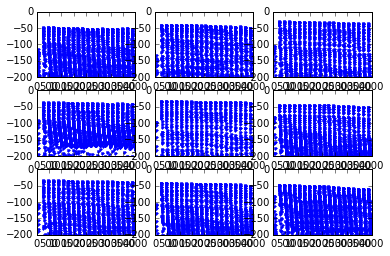

In [14]:
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    plt.ylim(-200, 0)

In [15]:
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

# Record the values of best fit x for each CD combination
bestx = np.zeros((nCD, nSub))

for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    bestx[:,si] = bestXcd[maxParId[si],:,si]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])

In [16]:
for si in range(nSub):
    print(totLL[maxParId[si],si])

-47.9360676189
-39.9061570095
-29.8348912779
-36.3159352718
-31.7975313109
-43.4133327264
-33.7663532487
-41.6558807907
-48.5548123429


In [17]:
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(round(As[maxParId[si]],ndigits=3), round(ks[maxParId[si]],ndigits=3), round(tRs[maxParId[si]],ndigits=3))
    # print(np.reshape(bestXcd[maxParId[si],:,si],(4,5)))
    print(bestXcd[maxParId[si],:,si])

(1.5, 0.358, 0.053)
[  3.   5.   2.   4.   5.  14.  14.  22.  19.  25.  27.  30.  42.  92.  93.
  94.]
(1.5, 0.616, 0.158)
[  1.   3.   3.   4.   7.  23.  23.  20.  12.  31.  31.  28.   6.  54.  60.
  63.]
(1.5, 0.358, -0.158)
[ 12.   7.   4.   3.   6.  31.  28.  27.  24.  49.  56.  53.  35.  72.  84.
  84.]
(1.5, 0.358, -0.368)
[  6.   4.   3.   8.   5.  25.  30.  29.  19.  49.  47.  55.  27.  60.  70.
  70.]
(1.5, 0.358, -0.474)
[  3.   3.   2.   6.  12.  33.  37.  34.  28.  49.  47.  52.  40.  64.  65.
  72.]
(1.5, 0.358, -0.474)
[  8.   2.   2.   5.  12.  23.  27.  27.  10.  31.  33.  37.  18.  48.  56.
  56.]
(1.5, 0.358, -0.263)
[  4.   3.   4.   2.   9.  36.  44.  43.  15.  54.  58.  59.  33.  62.  78.
  82.]
(1.5, 0.358, -0.263)
[  3.   2.   2.   5.  10.  37.  43.  40.  10.  55.  60.  62.  10.  54.  68.
  66.]
(1.5, 0.358, -0.474)
[  3.   7.   3.   5.   6.   5.   9.   7.   7.   9.   8.  12.  35.  54.  59.
  60.]


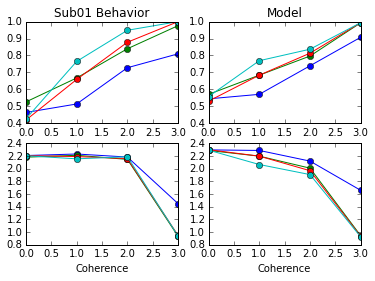

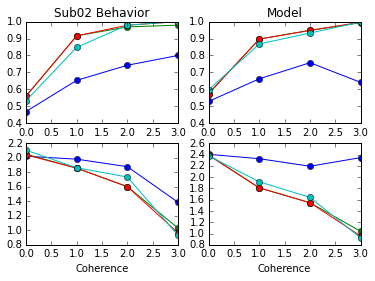

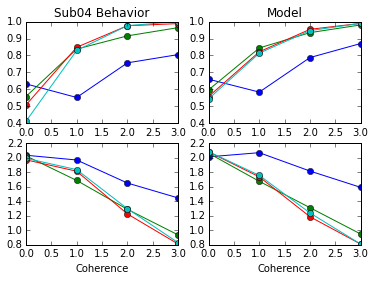

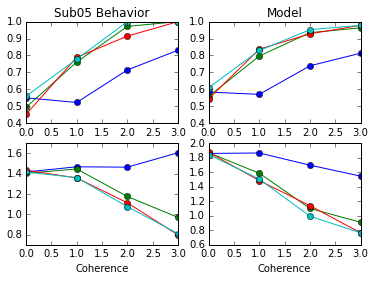

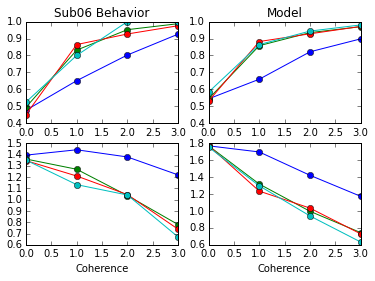

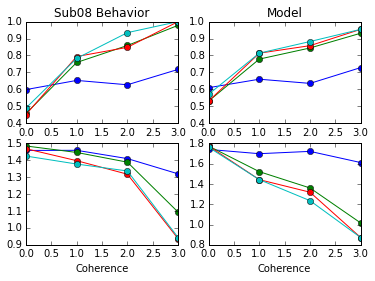

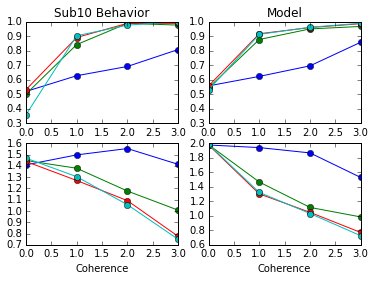

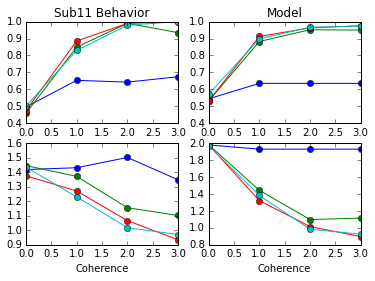

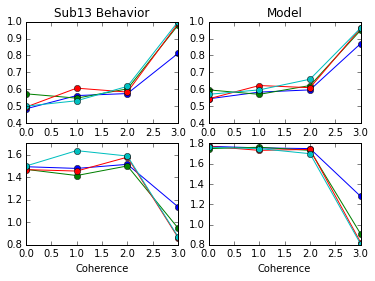

In [22]:
for si in range(nSub):
    temp = []
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(4,4)),'o-')
    ymin1, ymax1 = plt.ylim()
    plt.subplot(222)
    plt.title('Model')
    for cdi in range(nCD):
        temp.append(epc[maxParId[si], bestx[cdi,si], cdi, si])
    plt.plot(np.reshape(temp,(4,4)),'o-')
    ymin2, ymax2 = plt.ylim()
    plt.ylim(min(ymin1, ymin2),max(ymax1, ymax2))

    temp = []
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(4,4)),'o-')
    plt.xlabel('Coherence')
    ymin1, ymax1 = plt.ylim()
    plt.subplot(224)
    for cdi in range(nCD):
        temp.append(ert[maxParId[si], bestx[cdi,si], cdi, si])
    plt.plot(np.reshape(temp,(4,4)),'o-')
    plt.xlabel('Coherence')
    ymin2, ymax2 = plt.ylim()
    plt.ylim(min(ymin1, ymin2),max(ymax1, ymax2))

In [21]:
pCs.reshape((4,4))

ValueError: total size of new array must be unchanged

In [23]:
minA = np.zeros(nSub)
maxA = np.zeros(nSub)
mink = np.zeros(nSub)
maxk = np.zeros(nSub)
mintR = np.zeros(nSub)
maxtR = np.zeros(nSub)

nd = 4 # Number of deltas before and after best fit value

for si in range(nSub):
    # Set up A, k and tR parameters for the next round of simulations
    # Use the bestx values from the first run, don't fit for x again
    
    # First set the range of all variables. 
    # minVar = bestValue - dVar*nd : bestValue + dVar*nd
    # If the new minimum is <= 0, then set it to the old minimum.
    minA[si] = As[maxParId[si]] - nd * dA
    maxA[si] = As[maxParId[si]] + nd * dA
    if minA[si] < 0:
        minA[si] = A[0]
    
    mink[si] = ks[maxParId[si]] - nd * dk
    maxk[si] = ks[maxParId[si]] + nd * dk
    if mink[si] < 0:
        mink[si] = k[0]
        
    mintR[si] = tRs[maxParId[si]] - nd * dtR
    maxtR[si] = tRs[maxParId[si]] + nd * dtR
    if mintR[si] < 0:
        mintR[si] = tR[0]

In [24]:
print(minA.round(decimals=3))
print(maxA.round(decimals=3))
print(mink.round(decimals=3))
print(maxk.round(decimals=3))
print(mintR.round(decimals=3))
print(maxtR.round(decimals=3))

[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
[ 3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5]
[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
[ 1.389  1.647  1.389  1.389  1.389  1.389  1.389  1.389  1.389]
[-1. -1. -1. -1. -1. -1. -1. -1. -1.]
[ 0.474  0.579  0.263  0.053 -0.053 -0.053  0.158  0.158 -0.053]


In [25]:
A = np.zeros((10, nSub))
dA = np.zeros(nSub)
k = np.zeros((10, nSub))
dk = np.zeros(nSub)
tR = np.zeros((10, nSub))
dtR = np.zeros(nSub)

As = np.zeros((1000, nSub))
ks = np.zeros((1000, nSub))
tRs = np.zeros((1000, nSub))

nStep = 10 # Number of values tested, per parameter

for si in range(nSub):
    A[:,si], dA[si] = np.linspace(minA[si], maxA[si], nStep, retstep=True)
    k[:,si], dk[si] = np.linspace(mink[si], maxk[si], nStep, retstep=True)
    tR[:,si], dtR[si] = np.linspace(mintR[si], maxtR[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A[:,si], k[:,si], tR[:,si])
    As[:,si] = tempAs.flatten()
    ks[:,si] = tempks.flatten()
    tRs[:,si] = temptRs.flatten()

    # This is the overall number of permutations of A, k and tR being performed
    nPar = len(A) * len(k) * len(tR)
    
    # Initialize arrays that hold predicted accuracies and RTs
    epc = np.ones((nPar, nCD, 9)) * -9
    ert = np.ones((nPar, nCD, 9)) * -9
    sdrt = np.ones((nPar, nCD, 9)) * -9

    ## Initialize the array that holds the
    # individual likelihood values
    lpc = np.zeros((nPar, nCD, 9))
    lrt = np.zeros((nPar, nCD, 9))
    # final likelihood values
    ll = np.ones((nPar, 9)) * -9

In [27]:
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(nCD):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,cdi,si] = 1 / (1 + np.exp(-2 * As[pi,si] * ks[pi,si] * abs(x[bestx[cdi,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc[pi,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))

            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,cdi,si] = As[pi,si] / (ks[pi,si] * x[bestx[cdi,si]]) * \
                                np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) + tRs[pi,si] 
            # Calculate SD of mean RT 
            sdrt[pi,cdi,si] = np.sqrt(((As[pi,si] * np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) - \
                                As[pi,si] * ks[pi,si] * x[bestx[cdi,si]] * \
                                (1/np.cosh(np.square(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]])))) / \
                                (ks[pi,si] * x[bestx[cdi,si]]) ** 3 + np.square(0.1 * tRs[pi,si])) / Ns[cdi,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt[pi,cdi,si] = 1 / (sdrt[pi,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,cdi,si] - mRTs[cdi,si]) / sdrt[pi,cdi,si]))

In [28]:
#maxLLcd = np.ones((nPar, nCD, nSub)) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # maxLLcd[pi,:,si] = np.argmax(lpc[pi,:,:,si]+lrt[pi,:,:,si],0)
        for cdi in range(nCD):
            totLL[pi,si] += np.log(lpc[pi,cdi,si]) + \
                                np.log(lrt[pi,cdi,si])

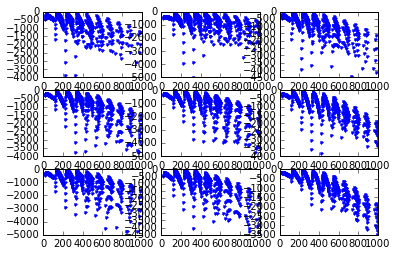

In [29]:
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')

In [30]:
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])

In [31]:
for si in range(nSub):
    print(totLL[maxParId[si],si])

-48.7636707598
-45.8516999376
-34.9735417005
-36.8833434784
-32.6898505519
-44.2477415178
-35.8161898567
-38.1923300352
-45.3582939597


In [32]:
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(round(As[maxParId[si],si],ndigits=3), round(ks[maxParId[si],si],ndigits=3), \
          round(tRs[maxParId[si],si],ndigits=3))
    # print(np.reshape(maxLLcd[maxParId[si],:,si],(4,5)))

(1.5, 0.387, 0.146)
(1.5, 0.616, 0.228)
(1.5, 0.387, -0.158)
(1.5, 0.387, -0.298)
(1.5, 0.387, -0.368)
(1.5, 0.387, -0.368)
(1.5, 0.387, -0.228)
(1.167, 0.387, 0.158)
(1.167, 0.387, -0.053)


In [ ]:
print(pCs[:,0])
print(pCs[:,0].reshape(4,5))
print(pCs[4:,0])
print(pCs[4:,0].reshape(4,4))

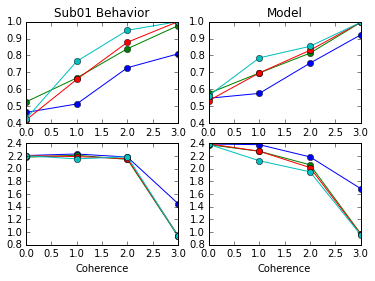

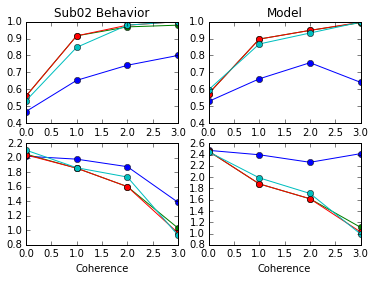

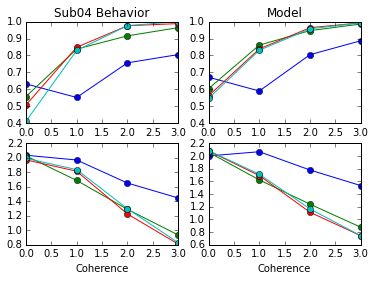

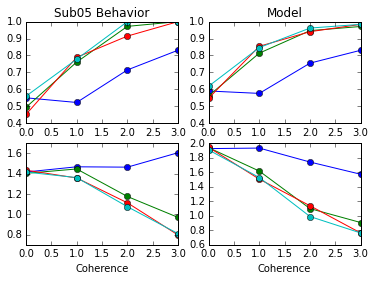

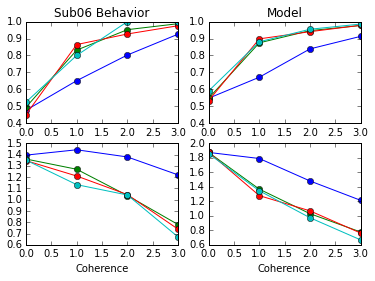

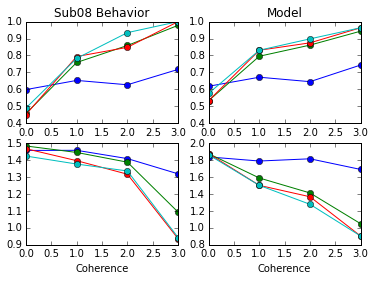

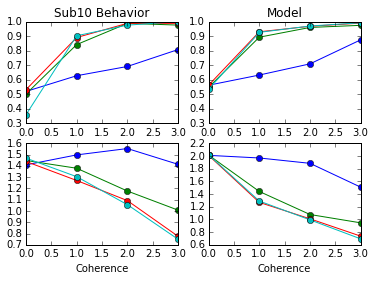

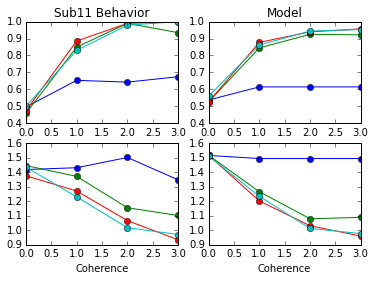

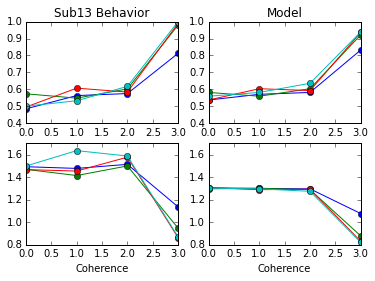

In [33]:
for si in range(nSub):
    temp = []
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(4,4)),'o-')
    ymin1, ymax1 = plt.ylim()
    plt.subplot(222)
    plt.title('Model')
    for cdi in range(nCD):
        temp.append(epc[maxParId[si],cdi,si])
    plt.plot(np.reshape(temp,(4,4)),'o-')
    ymin2, ymax2 = plt.ylim()
    plt.ylim(min(ymin1, ymin2),max(ymax1, ymax2))

    temp = []
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(4,4)),'o-')
    plt.xlabel('Coherence')
    ymin1, ymax1 = plt.ylim()
    plt.subplot(224)
    for cdi in range(nCD):
        temp.append(ert[maxParId[si],cdi,si])
    plt.plot(np.reshape(temp,(4,4)),'o-')
    plt.xlabel('Coherence')
    ymin2, ymax2 = plt.ylim()
    plt.ylim(min(ymin1, ymin2),max(ymax1, ymax2))
    

-54.5085064349
-48.0419355124
-31.5410274096
-32.0419861341
-29.023508605
-38.5701870919
-30.9168599326
-31.3059803952
-34.5248676843
(1.6479999999999999, 0.29099999999999998, -0.19900000000000001)
(1.3520000000000001, 0.63500000000000001, 0.28699999999999998)
(1.3520000000000001, 0.38700000000000001, 0.091999999999999998)
(1.3520000000000001, 0.38700000000000001, -0.089999999999999997)
(1.3520000000000001, 0.38700000000000001, -0.18099999999999999)
(1.3520000000000001, 0.38700000000000001, -0.18099999999999999)
(1.3520000000000001, 0.38700000000000001, 0.001)
(1.167, 0.48199999999999998, 0.30099999999999999)
(1.167, 0.57799999999999996, 0.216)


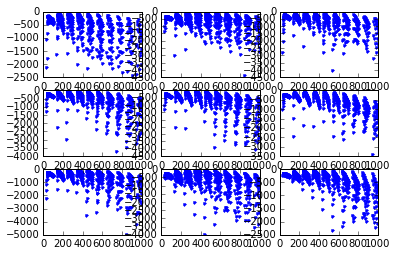

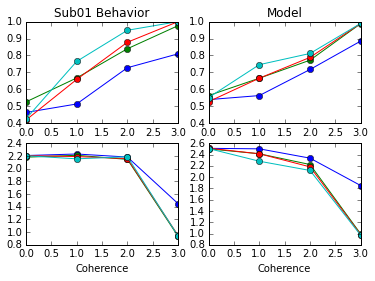

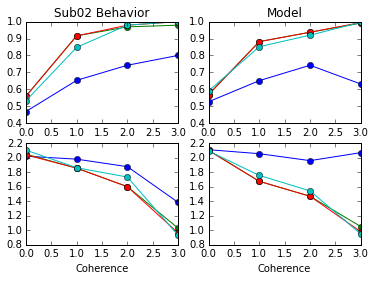

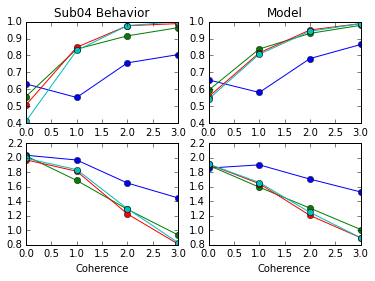

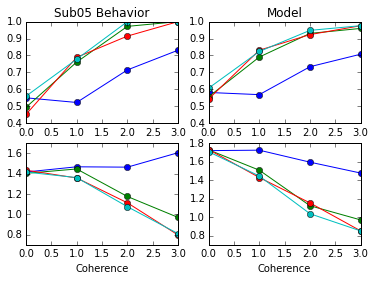

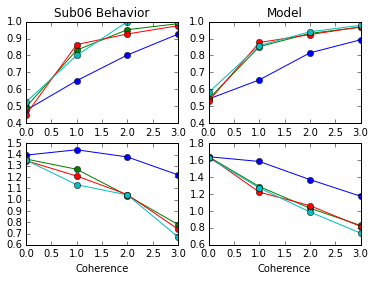

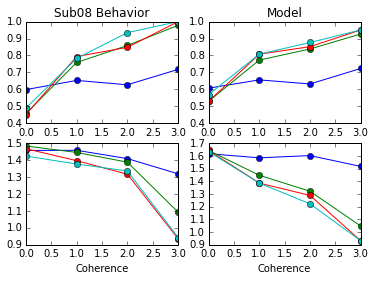

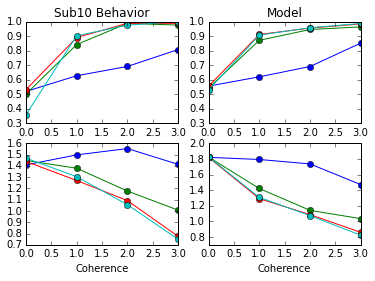

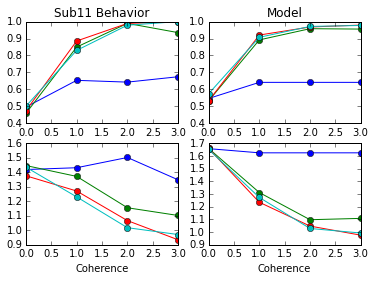

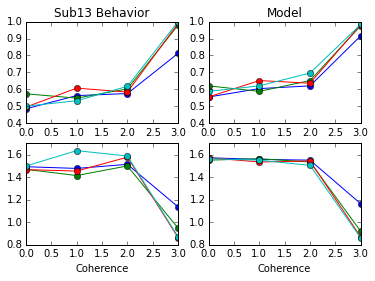

In [34]:
minA = np.zeros(nSub)
maxA = np.zeros(nSub)
mink = np.zeros(nSub)
maxk = np.zeros(nSub)
mintR = np.zeros(nSub)
maxtR = np.zeros(nSub)

nd = 4 # Number of deltas before and after best fit value

for si in range(nSub):
    # Set up A, k and tR parameters for the next round of simulations
    # Use the bestx values from the first run, don't fit for x again
    
    # First set the range of all variables. 
    # minVar = bestValue - dVar*nd : bestValue + dVar*nd
    # If the new minimum is <= 0, then set it to the old minimum.
    minA[si] = As[maxParId[si],si] - nd * dA[si]
    maxA[si] = As[maxParId[si],si] + nd * dA[si]
    if minA[si] < 0:
        minA[si] = A[0,si]
    
    mink[si] = ks[maxParId[si],si] - nd * dk[si]
    maxk[si] = ks[maxParId[si],si] + nd * dk[si]
    if mink[si] < 0:
        mink[si] = k[0,si]
        
    mintR[si] = tRs[maxParId[si],si] - nd * dtR[si]
    maxtR[si] = tRs[maxParId[si],si] + nd * dtR[si]
    if mintR[si] < 0:
        mintR[si] = tR[0,si]
        
A = np.zeros((10, nSub))
dA = np.zeros(nSub)
k = np.zeros((10, nSub))
dk = np.zeros(nSub)
tR = np.zeros((10, nSub))
dtR = np.zeros(nSub)

As = np.zeros((1000, nSub))
ks = np.zeros((1000, nSub))
tRs = np.zeros((1000, nSub))

nStep = 10 # Number of values tested, per parameter

for si in range(nSub):
    A[:,si], dA[si] = np.linspace(minA[si], maxA[si], nStep, retstep=True)
    k[:,si], dk[si] = np.linspace(mink[si], maxk[si], nStep, retstep=True)
    tR[:,si], dtR[si] = np.linspace(mintR[si], maxtR[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A[:,si], k[:,si], tR[:,si])
    As[:,si] = tempAs.flatten()
    ks[:,si] = tempks.flatten()
    tRs[:,si] = temptRs.flatten()

    # This is the overall number of permutations of A, k and tR being performed
    nPar = len(A) * len(k) * len(tR)
    
    # Initialize arrays that hold predicted accuracies and RTs
    epc = np.ones((nPar, nCD, 9)) * -9
    ert = np.ones((nPar, nCD, 9)) * -9
    sdrt = np.ones((nPar, nCD, 9)) * -9

    ## Initialize the array that holds the
    # individual likelihood values
    lpc = np.zeros((nPar, nCD, 9))
    lrt = np.zeros((nPar, nCD, 9))
    # final likelihood values
    ll = np.ones((nPar, 9)) * -9
    
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(nCD):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,cdi,si] = 1 / (1 + np.exp(-2 * As[pi,si] * ks[pi,si] * abs(x[bestx[cdi,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc[pi,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))

            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,cdi,si] = As[pi,si] / (ks[pi,si] * x[bestx[cdi,si]]) * \
                                np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) + tRs[pi,si] 
            # Calculate SD of mean RT 
            sdrt[pi,cdi,si] = np.sqrt(((As[pi,si] * np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) - \
                    As[pi,si] * ks[pi,si] * x[bestx[cdi,si]] * \
                    (1/np.cosh(np.square(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]])))) / \
                    (ks[pi,si] * x[bestx[cdi,si]]) ** 3 + np.square(0.1 * tRs[pi,si])) / Ns[cdi,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt[pi,cdi,si] = 1 / (sdrt[pi,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,cdi,si] - mRTs[cdi,si]) / sdrt[pi,cdi,si]))
                
#maxLLcd = np.ones((nPar, nCD, nSub)) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # maxLLcd[pi,:,si] = np.argmax(lpc[pi,:,:,si]+lrt[pi,:,:,si],0)
        for cdi in range(nCD):
            totLL[pi,si] += np.log(lpc[pi,cdi,si]) + \
                                np.log(lrt[pi,cdi,si])
                
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])
    
for si in range(nSub):
    print(totLL[maxParId[si],si])
    
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(As[maxParId[si],si].round(decimals=3), ks[maxParId[si],si].round(decimals=3), \
          tRs[maxParId[si],si].round(decimals=3))
    # print(np.reshape(maxLLcd[maxParId[si],:,si],(4,5)))
    
for si in range(nSub):
    temp = []
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(4,4)),'o-')
    ymin1, ymax1 = plt.ylim()
    plt.subplot(222)
    for cdi in range(nCD):
        temp.append(epc[maxParId[si],cdi,si])
    plt.plot(np.reshape(temp,(4,4)),'o-')
    plt.title('Model')
    ymin2, ymax2 = plt.ylim()
    plt.ylim(min(ymin1,ymin2),max(ymax1,ymax2))

    temp = []
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(4,4)),'o-')
    plt.xlabel('Coherence')
    ymin1, ymax1 = plt.ylim()
    plt.subplot(224)
    for cdi in range(nCD):
        temp.append(ert[maxParId[si],cdi,si])
    plt.plot(np.reshape(temp,(4,4)),'o-')
    plt.xlabel('Coherence')
    ymin2, ymax2 = plt.ylim()
    plt.ylim(min(ymin1,ymin2),max(ymax1,ymax2))